<a href="https://colab.research.google.com/github/taliadagan/hello-world/blob/main/Capstone_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google Drive

Uploading the file

In [1]:
from google.colab import files
uploaded = files.upload()

Saving tiktok_google_play_reviews 2.csv to tiktok_google_play_reviews 2.csv


In [2]:
#reading the file
df= "tiktok_google_play_reviews 2.csv"

In [3]:
import pandas as pd
import numpy as np

Installing necessary packages

In [4]:
! pip install nltk
! pip install stopwords
!pip install -q -U watermark
!pip install -qq transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 6.6 MB 3.4 MB/s 


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.21.0



Configuration 

In [6]:
#Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

EDA

In [7]:
df = pd.read_csv("tiktok_google_play_reviews 2.csv")

In [8]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHRz-11c0apHLSKHHp52FxUXsQS9Z88wP3sWc5...,MR LOL GAMER,https://play-lh.googleusercontent.com/a/AATXAJ...,Good,5,0,23.8.4,2022-04-05 23:18:30,NaN,NaN
1,gp:AOqpTOF6mFDEkIypmyT3shDLjPHg8zB3kdns2W36ahp...,Dino Kljako,https://play-lh.googleusercontent.com/a-/AOh14...,Awesome app! Too many people on it where it's ...,5,0,NaN,2022-04-05 23:18:21,NaN,NaN
2,gp:AOqpTOGtqU4sb8vuVo3-eB7kIXWoBn-0YCUZ1SnPRKS...,Olivia Harding,https://play-lh.googleusercontent.com/a/AATXAJ...,Not bad,5,0,23.9.5,2022-04-05 23:17:34,NaN,NaN
3,gp:AOqpTOFHDm-Qa5R6jCpOGTFT2qr1_PKbCTbBNPahCEn...,Keli We,https://play-lh.googleusercontent.com/a-/AOh14...,It is good,2,0,22.2.5,2022-04-05 23:17:04,NaN,NaN
4,gp:AOqpTOFB6Ndao8IHRpOJRmbSknwMGxHcwYzux93YyXI...,Mavis Kotoka,https://play-lh.googleusercontent.com/a/AATXAJ...,Very interesting app,5,0,22.1.5,2022-04-05 23:17:04,NaN,NaN


In [9]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307057 entries, 0 to 307056
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              307057 non-null  object
 1   userName              307057 non-null  object
 2   userImage             307057 non-null  object
 3   content               307053 non-null  object
 4   score                 307057 non-null  int64 
 5   thumbsUpCount         307057 non-null  int64 
 6   reviewCreatedVersion  217841 non-null  object
 7   at                    307057 non-null  object
 8   replyContent          119 non-null     object
 9   repliedAt             119 non-null     object
dtypes: int64(2), object(8)
memory usage: 23.4+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


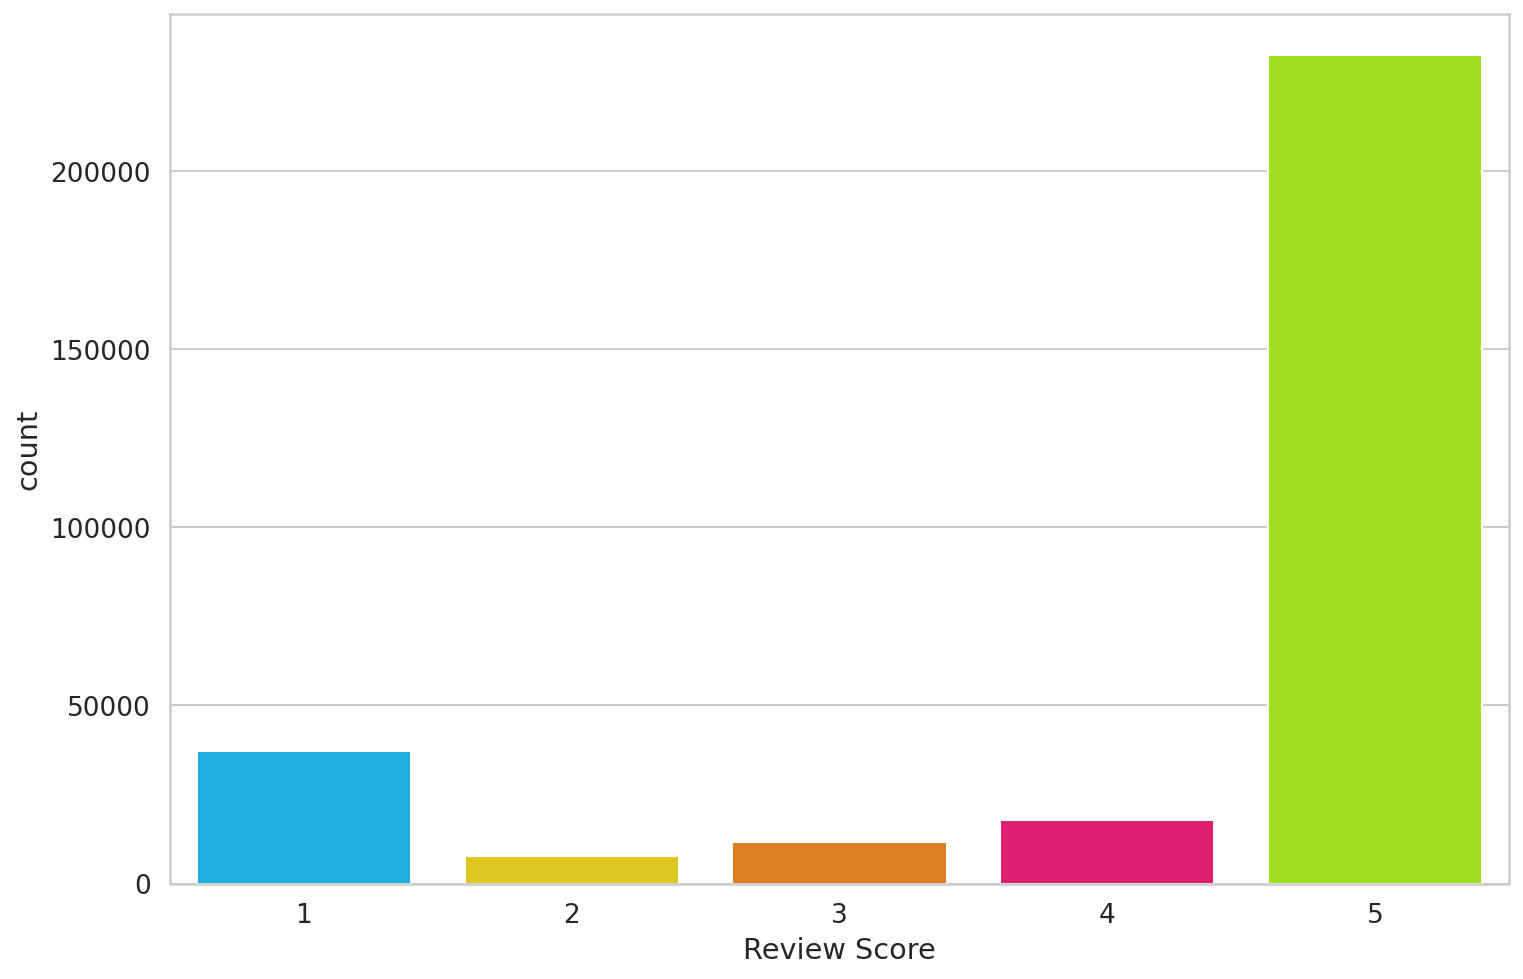

In [10]:
sns.countplot(df.score)
plt.xlabel('Review Score');

In [11]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [12]:
class_names = ['negative', 'unbiased', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


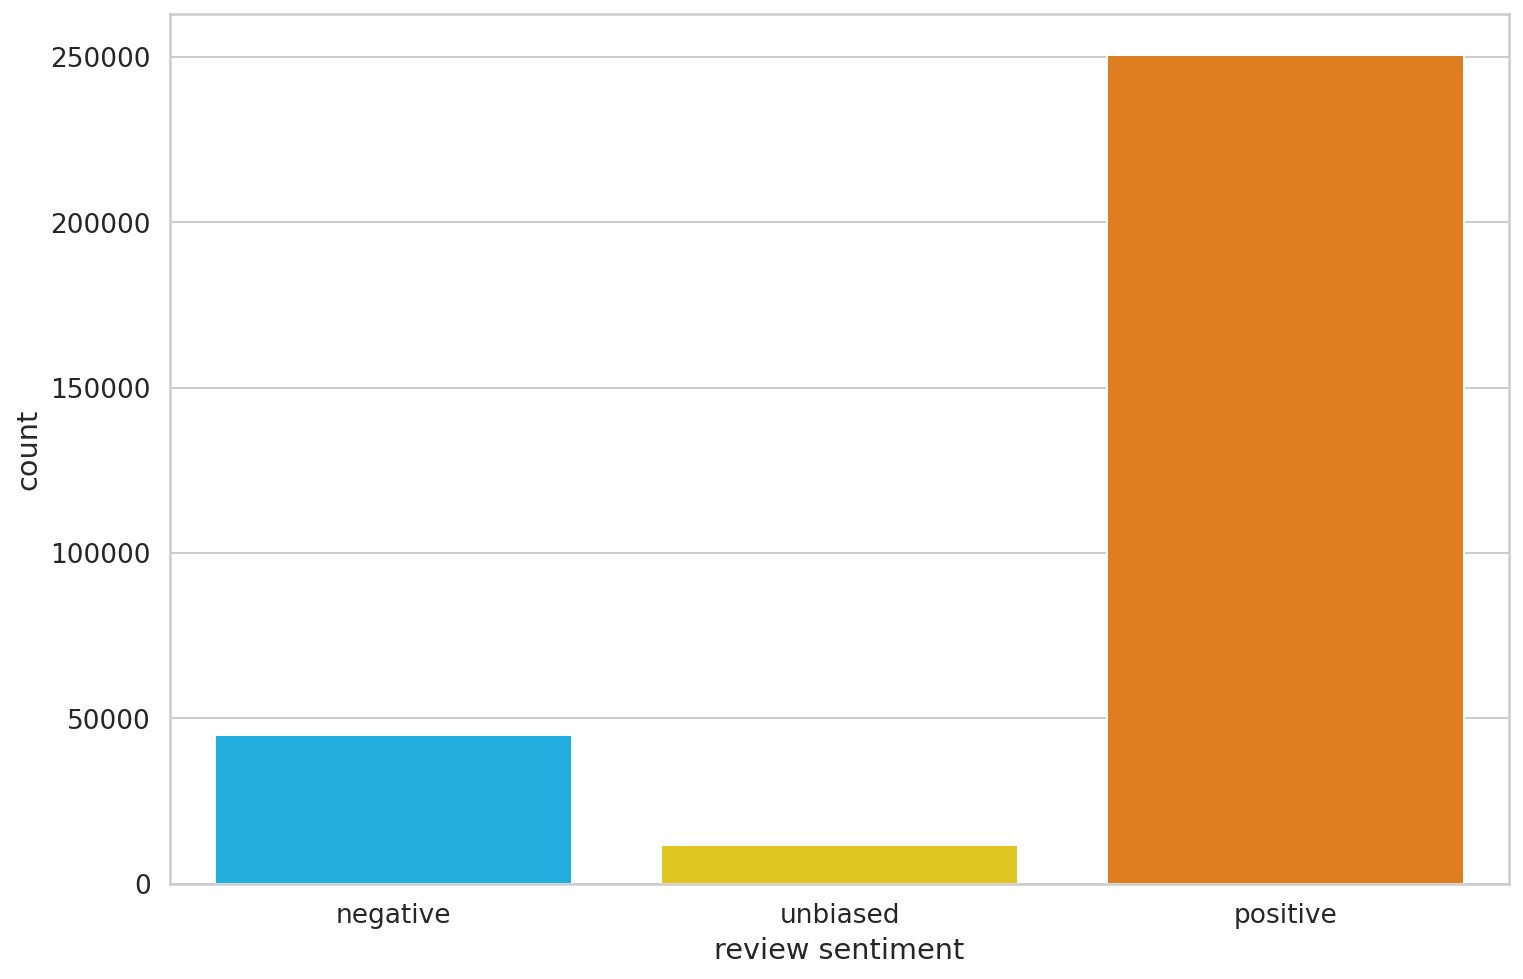

In [13]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Data Preprocessing

In [14]:
pre_trained_model = 'bert-base-cased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model)

In [16]:
sample = 'school is almost over!.'

In [17]:
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: school is almost over!.
   Tokens: ['school', 'is', 'almost', 'over', '!', '.']
Token IDs: [1278, 1110, 1593, 1166, 106, 119]


Special Tokens

Example with sample text to show how tokens work. 

In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [20]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [21]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [23]:
encoding = tokenizer.encode_plus(
  sample,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1278, 1110, 1593, 1166,  106,  119,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'school',
 'is',
 'almost',
 'over',
 '!',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Choosing Sequence Length

In [27]:
df = df[df['content'].notna()]

In [28]:
token_lens = []

for txt in df.content:
  #print(txt)
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


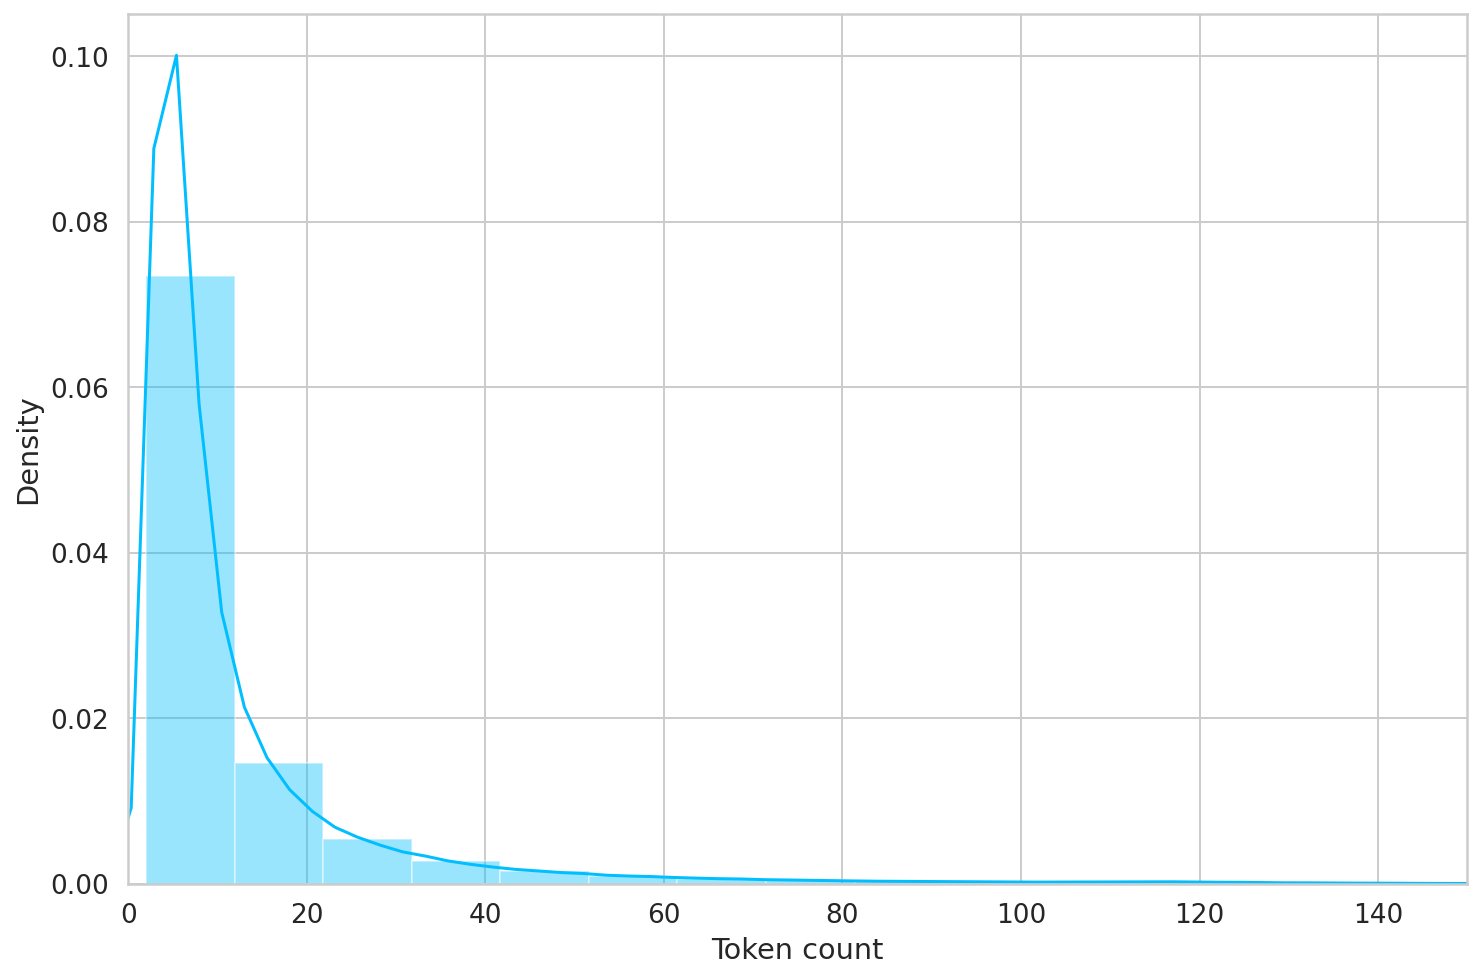

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 150]);
plt.xlabel('Token count');

In [30]:
MAX_LEN =  80

In [31]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [32]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((276347, 11), (15353, 11), (15353, 11))

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [36]:

BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 80])
torch.Size([32, 80])
torch.Size([32])


Sentiment Classification with BERT and Hugging Face

Using the basic BertModel and building sentiment classifier on top 

In [39]:
bert_model = BertModel.from_pretrained(pre_trained_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'], return_dict=False 
)

In [41]:
last_hidden_state

tensor([[[ 0.0040,  0.3592,  0.1207,  ..., -0.2964,  0.2386,  0.2226],
         [-0.1407,  0.0236,  0.3144,  ..., -0.2582,  0.0284,  0.1373],
         [ 0.1177,  0.5464,  0.3143,  ..., -0.6173,  0.1870,  0.5170],
         ...,
         [-0.4759,  0.5248, -0.0046,  ...,  0.1095, -0.1472,  0.4930],
         [ 0.1331,  0.6173,  0.1273,  ...,  0.1267, -0.1599,  0.1634],
         [-0.0918,  0.5316,  0.0063,  ..., -0.1874, -0.0470, -0.0182]]],
       grad_fn=<NativeLayerNormBackward0>)

In [42]:
bert_model.config.hidden_size

768

In [43]:
pooled_output

tensor([[-0.7562,  0.5322,  0.9999, -0.9953,  0.9613,  0.8119,  0.9902, -0.9502,
         -0.9897, -0.6415,  0.9903,  0.9990, -0.9917, -0.9999,  0.5765, -0.9872,
          0.9909, -0.5729, -1.0000, -0.7949, -0.3528, -0.9999,  0.3969,  0.9268,
          0.9869,  0.0764,  0.9909,  1.0000,  0.8566,  0.1631,  0.3603, -0.9924,
          0.7738, -0.9989,  0.2526,  0.0101,  0.4717, -0.2848,  0.8164, -0.7507,
         -0.8079, -0.5984,  0.6642, -0.5926,  0.8055,  0.2399,  0.2579, -0.1405,
         -0.2106,  0.9999, -0.9777,  0.9999, -0.9699,  0.9991,  0.9971,  0.5361,
          0.9970,  0.1978, -0.9910,  0.6118,  0.9785,  0.0846,  0.9180, -0.2042,
          0.1570, -0.5690, -0.8512,  0.3457, -0.4042,  0.2560,  0.4855,  0.4574,
          0.9929, -0.9197, -0.0054, -0.9007,  0.4231, -0.9999,  0.9468,  1.0000,
          0.5168, -0.9998,  0.9959, -0.3429, -0.5347,  0.5803, -0.9869, -0.9996,
          0.0657, -0.7052,  0.9029, -0.9915,  0.4043, -0.7889,  1.0000, -0.7291,
         -0.1623,  0.3904,  

In [44]:
bert_model.config.hidden_size

768

In [47]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pre_trained_model)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [48]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 80])
torch.Size([32, 80])


In [50]:
type(input_ids)

torch.Tensor

In [51]:
type(attention_mask)

torch.Tensor

In [52]:
type(attention_mask)
mask = torch.as_tensor(attention_mask)

In [53]:
input_ids[1]

tensor([  101, 17784,  3970,  7983,  2491,  3828,   106,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

In [54]:
model(input_ids, mask)

tensor([[-0.4773, -0.7394, -0.3042],
        [-0.2239, -0.1792, -0.7001],
        [ 0.7863, -0.7652,  0.0249],
        [-0.0637,  0.0369, -0.1694],
        [ 0.2591, -0.5332, -0.3173],
        [-0.2125, -0.5738, -0.1053],
        [-0.0792, -0.8182, -0.5452],
        [ 0.2434,  0.1203,  0.0859],
        [ 0.2069,  0.1586, -0.1527],
        [-0.4674, -0.4878, -0.3410],
        [-0.1875, -0.6132, -0.7197],
        [-0.3186, -0.2454, -0.0559],
        [-0.2056, -0.6701, -0.4267],
        [-0.1900, -0.4017,  0.2702],
        [-0.0860, -0.1961,  0.2132],
        [-0.5439,  0.2198, -0.6508],
        [-0.2396,  0.0805, -0.4895],
        [ 0.0045, -0.1528, -0.0961],
        [ 0.4241, -0.2618,  0.1902],
        [-0.4463, -0.0922,  0.1409],
        [ 0.3570, -0.5906,  0.4156],
        [-0.3980,  0.2901,  0.1739],
        [-0.4379, -0.7349, -1.1039],
        [ 0.1828,  0.0086,  0.0115],
        [ 0.0556, -0.4843, -0.4430],
        [ 0.0281, -0.4677,  0.1101],
        [ 0.1434,  0.0174,  0.0012],
 

In [55]:
F.softmax(model(input_ids, attention_mask, ), dim=1)

tensor([[0.2252, 0.3191, 0.4557],
        [0.3322, 0.4368, 0.2309],
        [0.3783, 0.2634, 0.3583],
        [0.3524, 0.2308, 0.4169],
        [0.3930, 0.3671, 0.2399],
        [0.2248, 0.3309, 0.4443],
        [0.3986, 0.3070, 0.2944],
        [0.3346, 0.2374, 0.4279],
        [0.2995, 0.2238, 0.4767],
        [0.4478, 0.1519, 0.4002],
        [0.5085, 0.2673, 0.2241],
        [0.1984, 0.3824, 0.4192],
        [0.4187, 0.2514, 0.3299],
        [0.3552, 0.2908, 0.3540],
        [0.3533, 0.1864, 0.4604],
        [0.3058, 0.2660, 0.4282],
        [0.2515, 0.4244, 0.3241],
        [0.3137, 0.3255, 0.3608],
        [0.2903, 0.3709, 0.3388],
        [0.3968, 0.2971, 0.3060],
        [0.3824, 0.3880, 0.2296],
        [0.2441, 0.5524, 0.2035],
        [0.4156, 0.3556, 0.2288],
        [0.5613, 0.1865, 0.2522],
        [0.4090, 0.2445, 0.3465],
        [0.3033, 0.3165, 0.3801],
        [0.1975, 0.5714, 0.2310],
        [0.3825, 0.2856, 0.3319],
        [0.2718, 0.2221, 0.5061],
        [0.278

Training

Originally had 4 epochs but took too much computation time and no increase in accuracy.

In [56]:

EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [57]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [59]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.4410705151396142 accuracy 0.8577730172572888


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4174263642169535 accuracy 0.8662150719729044

Epoch 2/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.39941614737622905 accuracy 0.8722041491313457


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4264326372183859 accuracy 0.8647169934214811



In [60]:
history 

defaultdict(list,
            {'train_acc': [tensor(0.8578, device='cuda:0', dtype=torch.float64),
              tensor(0.8722, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.4410705151396142, 0.39941614737622905],
             'val_acc': [tensor(0.8662, device='cuda:0', dtype=torch.float64),
              tensor(0.8647, device='cuda:0', dtype=torch.float64)],
             'val_loss': [0.4174263642169535, 0.4264326372183859]})

In [61]:
history['train_acc'][0].item()

0.8577730172572888

In [62]:
history['val_acc'][0].item()

0.8662150719729044

In [65]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.8590503484660978

In [66]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [68]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.69      0.43      0.53      2190
    unbiased       0.39      0.08      0.13       645
    positive       0.88      0.97      0.92     12518

    accuracy                           0.86     15353
   macro avg       0.65      0.50      0.53     15353
weighted avg       0.83      0.86      0.84     15353



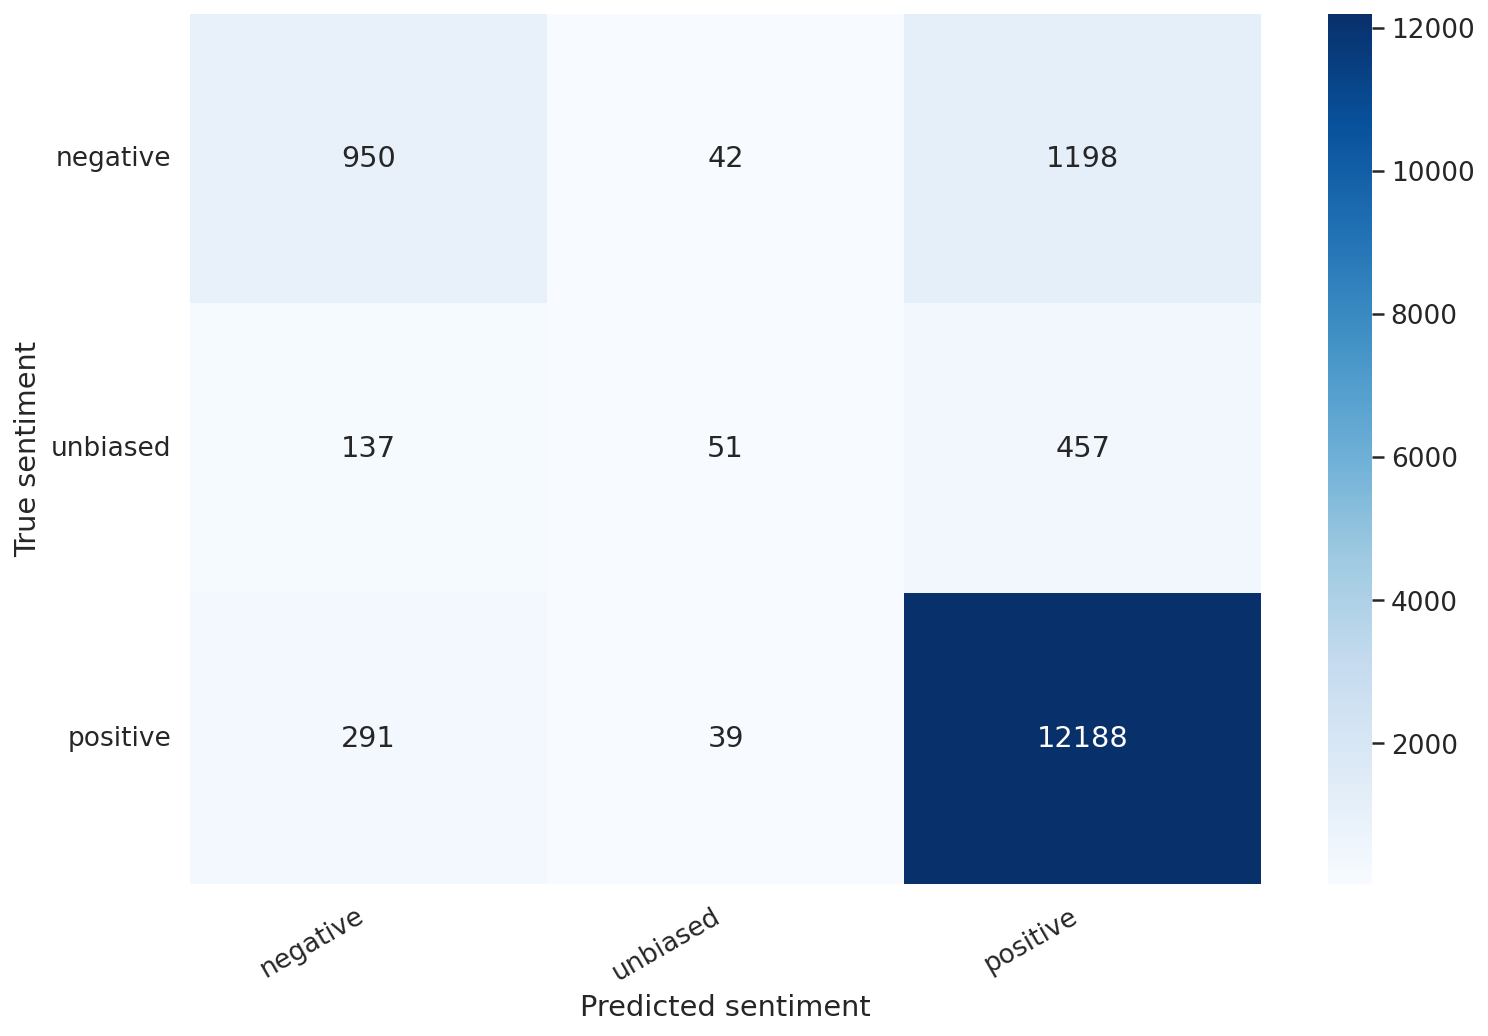

In [69]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [73]:
idx = 7

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

Example from my test data 

In [74]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Nice I love you tik too

True sentiment: positive


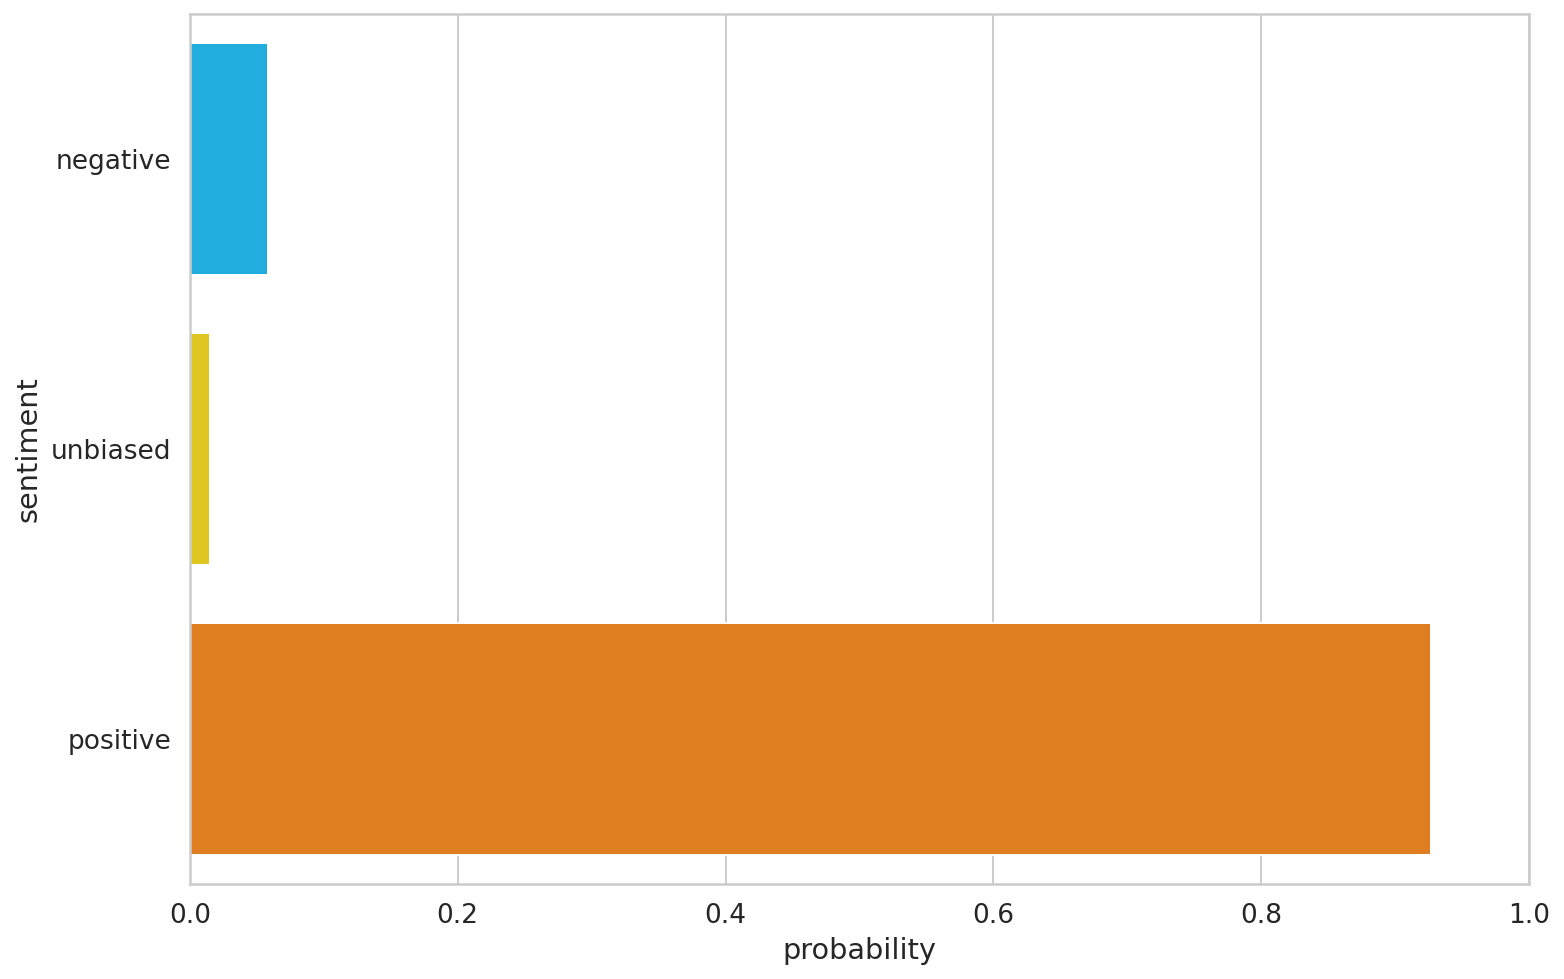

In [75]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting with raw text

In [76]:
review_text = "Tiktok is great. "
review_text1 = "Tiktok is the worst. I hate it. "
review_text2 = "Tiktok. "

In [77]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [78]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: Tiktok is great. 
Sentiment  : positive
